# Library

In [6]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
import os

# Function

In [7]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

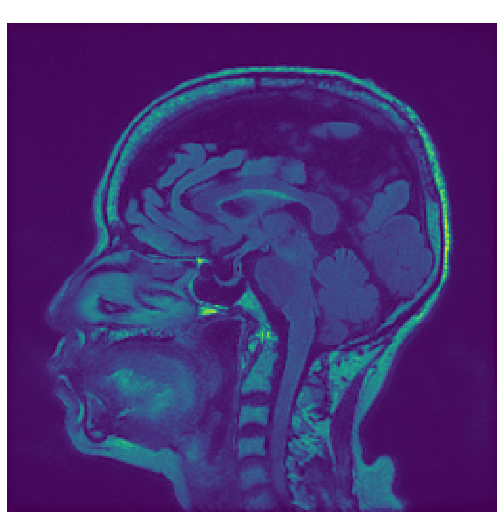

In [8]:
basepath ="C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\Simple_Brain_MRI_Segmentation\\dicom\\"
d = pydicom.read_file(basepath + "Z520")
file = np.array(d.pixel_array)
img = file

img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

ShowImage('Gambar',hasil,'rgb')

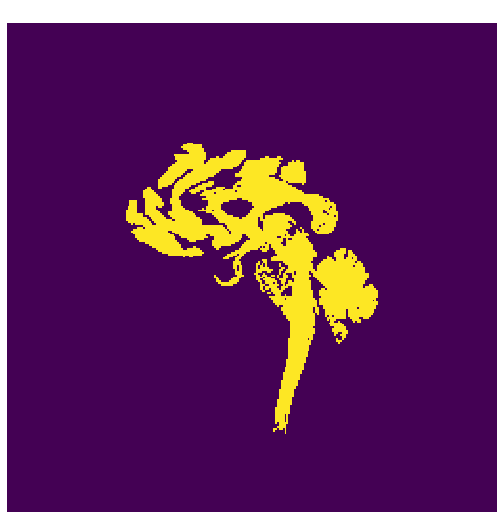

In [9]:
#OTSU THRESHOLDING
_,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

foreground_value = 255
mask = np.uint8(binarized == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
binarized = np.zeros_like(binarized)
binarized[labels == largest_label] = foreground_value
ShowImage('binarized',binarized,'rgb')

(5695, 1) K-means segmentation


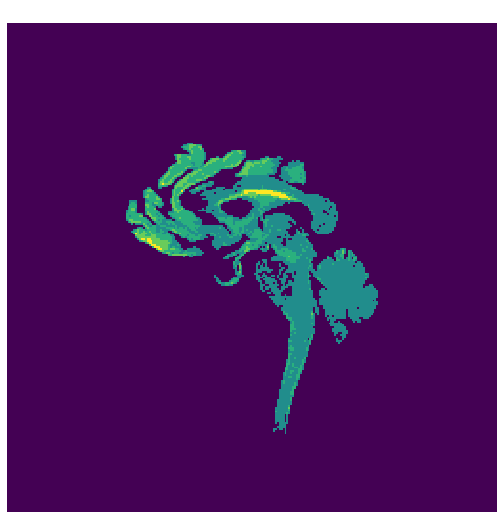

In [10]:
basepath ="C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\Simple_Brain_MRI_Segmentation\\dicom\\"
d = pydicom.read_file(basepath + "Z520")
file = np.array(d.pixel_array)
img = file

img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = binarized)
brain_pixels = skull_stripped_image[binarized == foreground_value]

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(brain_pixels.shape[0], brain_pixels.ndim))

# K-means parameters
epsilon = 2
number_of_iterations = 100
number_of_clusters = 4
number_of_repetition = 1
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS

# K-means segmentation
_, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)
print(labels.shape, 'K-means segmentation')

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

segmented_image = np.zeros_like(binarized)
segmented_image[binarized == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')    

# Fungsi Pembagi Warna

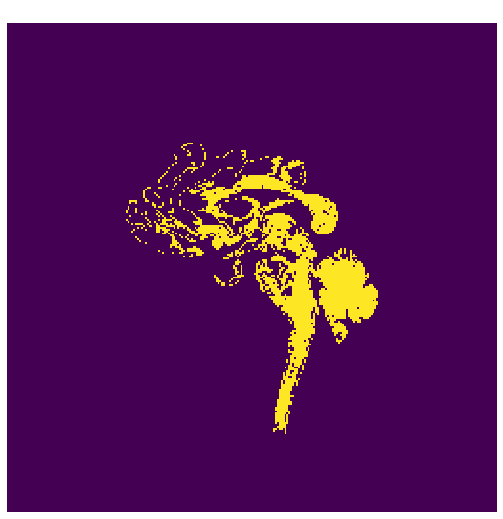

In [11]:
a=0
b=0
c=0
jml_a=0
jml_b=0
jml_c=0
jml_d=0

for x in range(256):
    for y in range(256):
        if segmented_image[x][y]==0:
            jml_d=jml_d+1
        elif segmented_image[x][y]!=0 and a==0:
            a=segmented_image[x][y]
            jml_a=jml_a+1
        elif segmented_image[x][y]!=0 and segmented_image[x][y]!=a and b==0:
            b=segmented_image[x][y]
            jml_b=jml_b+1
        elif segmented_image[x][y]!=0 and segmented_image[x][y]!=a and segmented_image[x][y]!=b and c==0:
            c=segmented_image[x][y]
            jml_c=jml_c+1
        elif segmented_image[x][y]==a:
            jml_a=jml_a+1
        elif segmented_image[x][y]==b:
            jml_b=jml_b+1
        elif segmented_image[x][y]==c:
            jml_c=jml_c+1

if jml_a>jml_b and jml_a>jml_c and jml_a>jml_d:
    if jml_b>jml_c and jml_b>jml_d:
        segmented_image[segmented_image!=b]=0
    elif jml_c>jml_b and jml_c>jml_d:
        segmented_image[segmented_image!=c]=0
    elif jml_d>jml_b and jml_d>jml_c:
        segmented_image[segmented_image!=d]=0
elif jml_b>jml_a and jml_b>jml_c and jml_b>jml_d:
    if jml_a>jml_c and jml_a>jml_d:
        segmented_image[segmented_image!=a]=0
    elif jml_c>jml_a and jml_c>jml_d:
        segmented_image[segmented_image!=c]=0
    elif jml_d>jml_a and jml_d>jml_c:
        segmented_image[segmented_image!=d]=0
elif jml_c>jml_a and jml_c>jml_b and jml_c>jml_d:
    if jml_a>jml_b and jml_a>jml_d:
        segmented_image[segmented_image!=a]=0
    elif jml_b>jml_a and jml_b>jml_d:
        segmented_image[segmented_image!=b]=0
    elif jml_d>jml_a and jml_d>jml_b:
        segmented_image[segmented_image!=d]=0
elif jml_d>jml_a and jml_d>jml_b and jml_d>jml_c:
    if jml_a>jml_b and jml_a>jml_c:
        segmented_image[segmented_image!=a]=0
    elif jml_b>jml_a and jml_b>jml_c:
        segmented_image[segmented_image!=b]=0
    elif jml_c>jml_a and jml_c>jml_b:
        segmented_image[segmented_image!=c]=0

ShowImage('Segmented Image',segmented_image,'rgb')

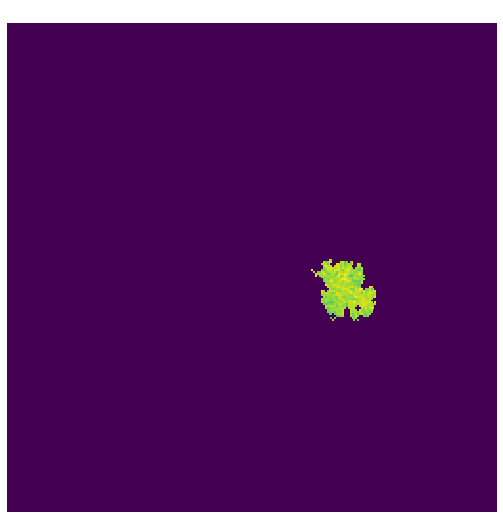

In [12]:
erosion_size = 1
kernel_erosion = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
erosion_dst = cv2.erode(segmented_image,kernel_erosion)

res2 = erosion_dst
ret1, markers1 = cv2.connectedComponents(res2)
marker_area1 = [np.sum(markers1==m1) for m1 in range(np.max(markers1)) if m1 != 0]
largest_component1 = np.argmax(marker_area1)+1                         
brain_mask1 = markers1==largest_component1
otak_opening = hasil
otak_opening[brain_mask1==False] = 0

ShowImage('opening',otak_opening, 'rgb')

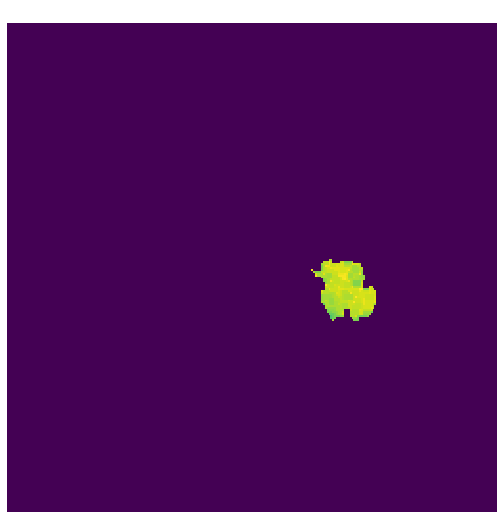

In [13]:
kernel = np.ones((3, 3), np.uint8)
closing = cv2.morphologyEx(otak_opening, cv2.MORPH_CLOSE, kernel)
ShowImage('closing',closing, 'rgb')

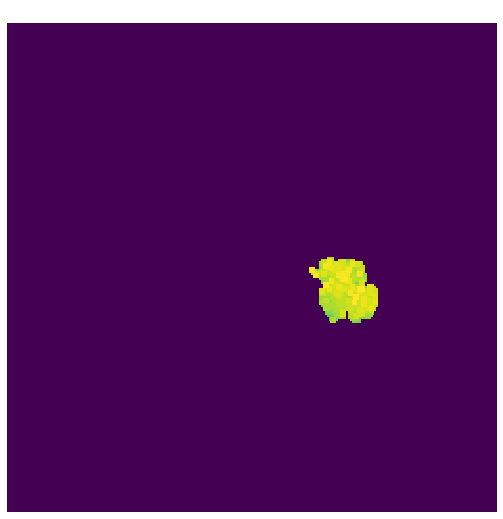

In [14]:
bentukan = np.ones((3, 3), np.uint8)
dilasi = cv2.dilate(closing,bentukan,iterations = 1)

ShowImage('dilasi',dilasi,'rgb')

# All in One Row

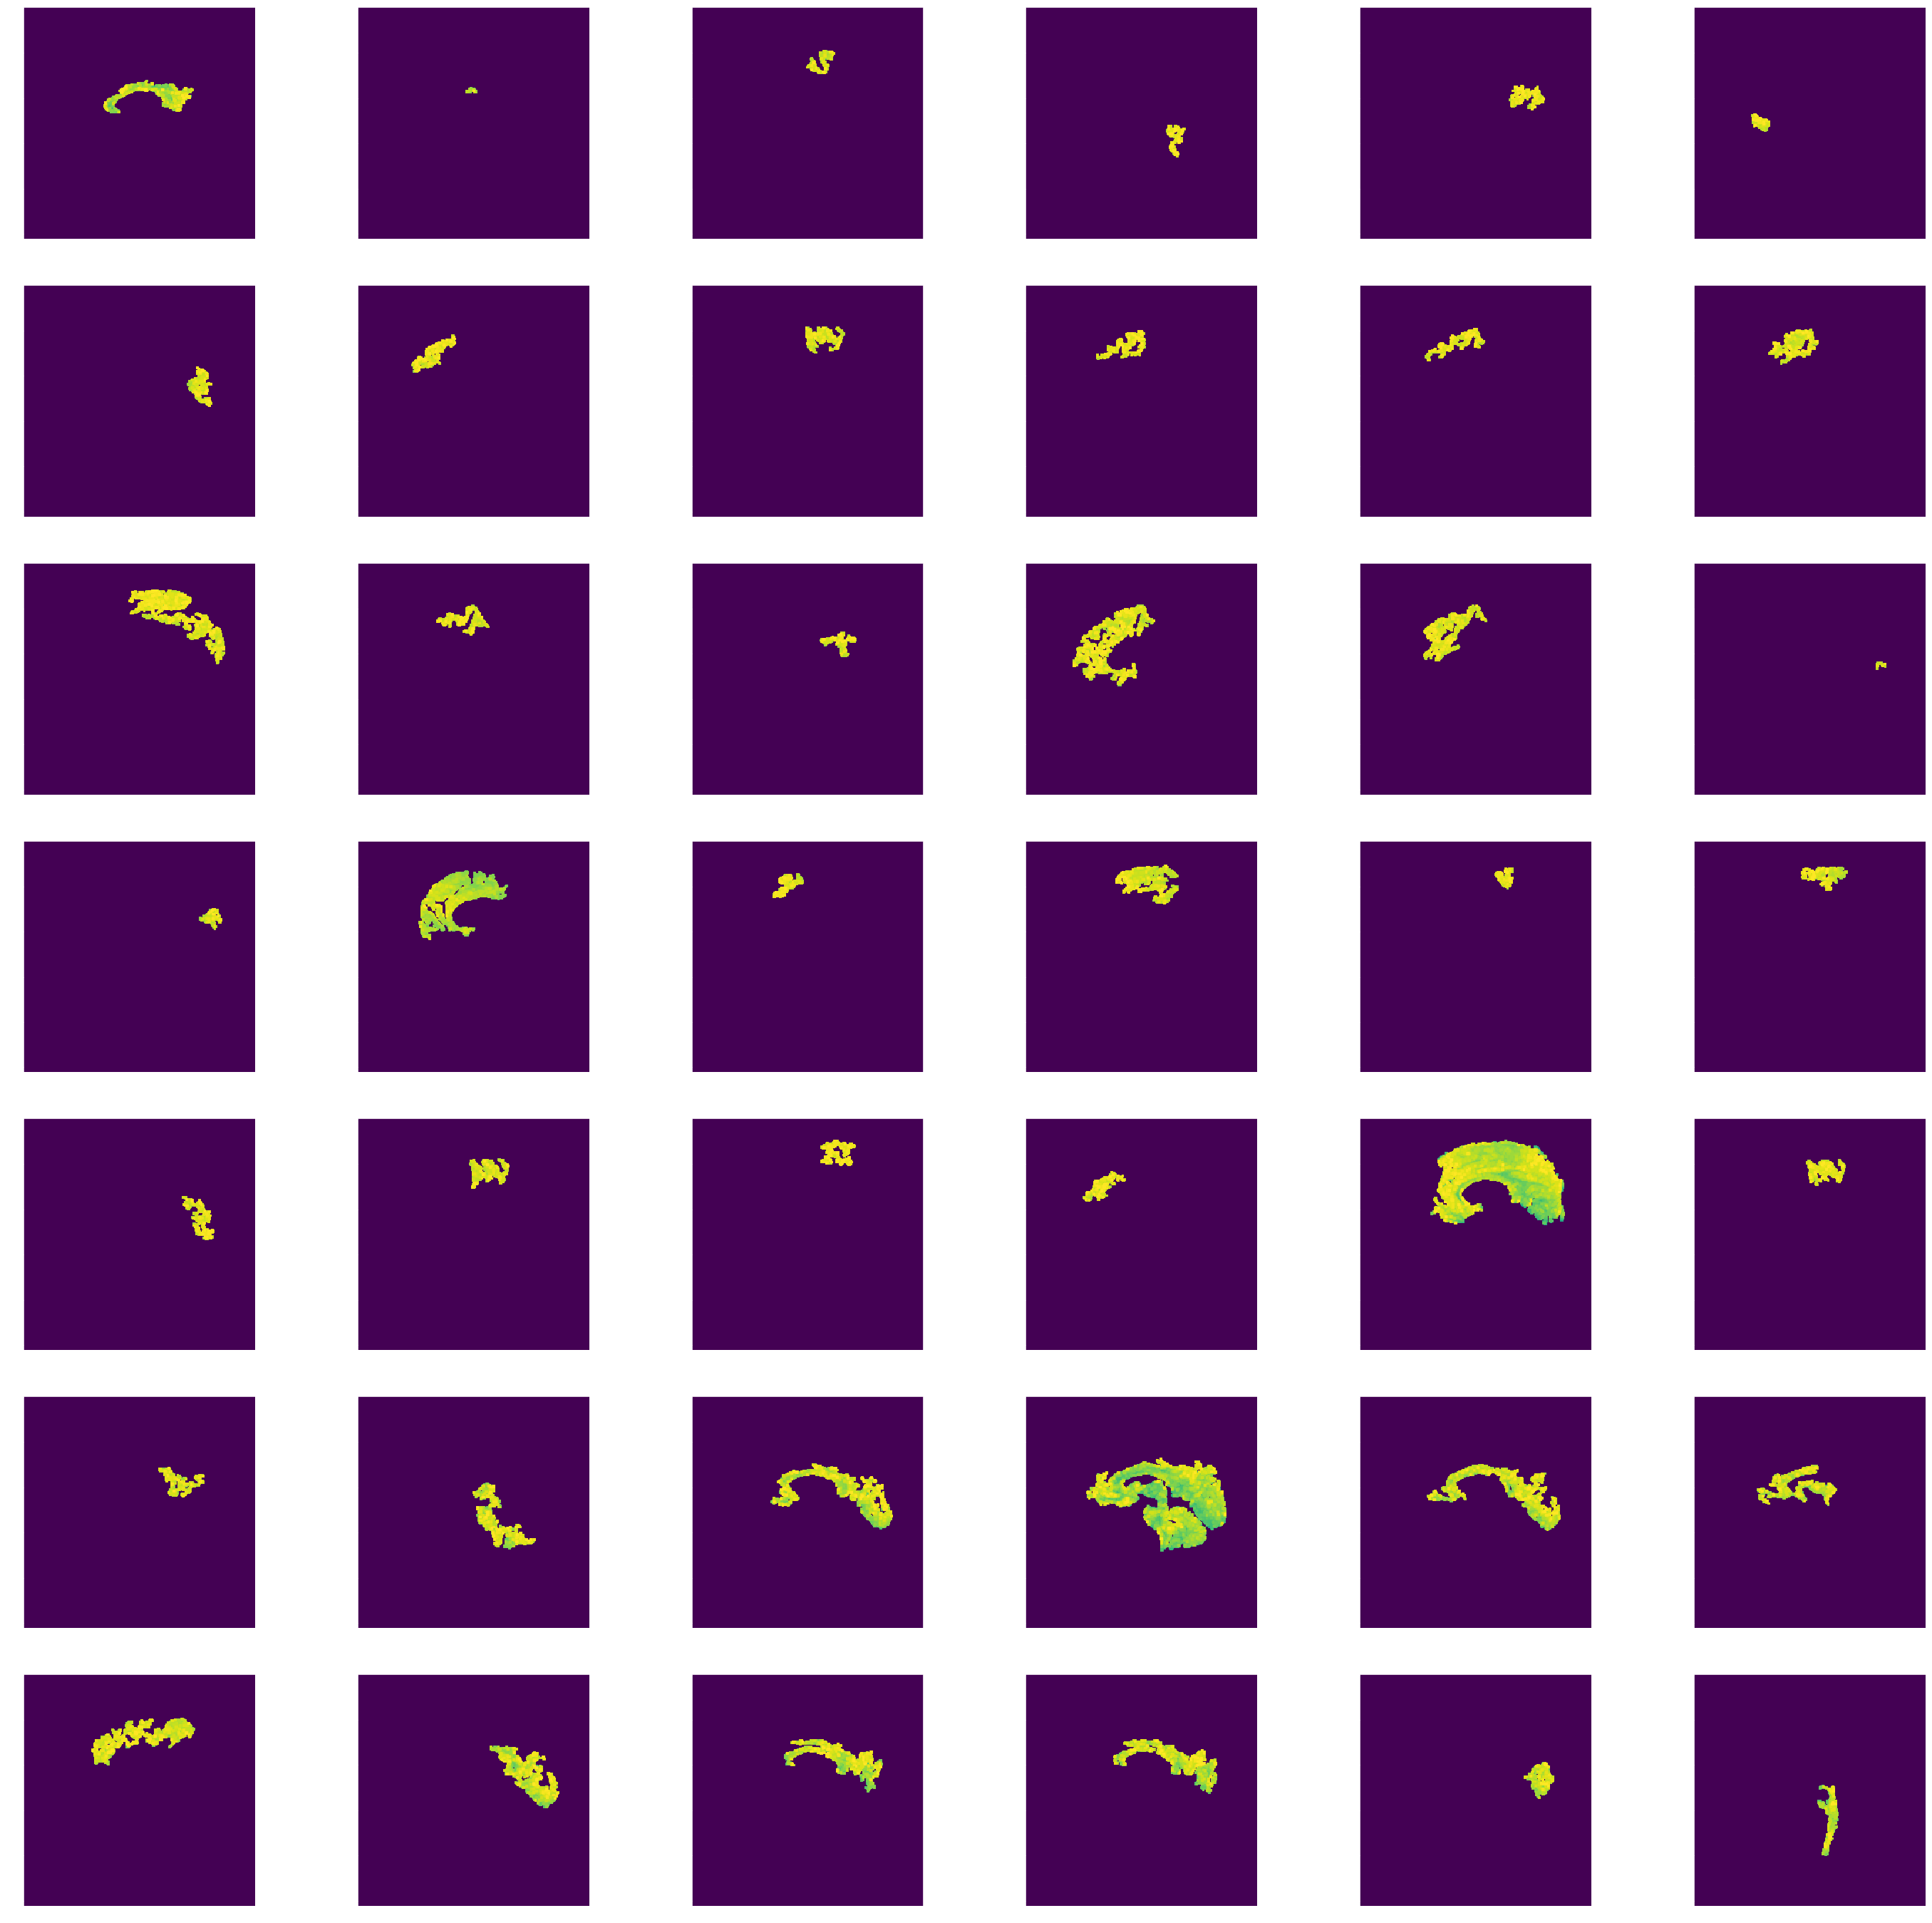

In [15]:
basepath ="C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\Simple_Brain_MRI_Segmentation\\dicom\\"
IMAGE_PATHS = os.listdir(basepath)

list_b = []
for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled

    #OTSU THRESHOLDING
    _,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    foreground_value = 255
    mask = np.uint8(binarized == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    binarized = np.zeros_like(binarized)
    binarized[labels == largest_label] = foreground_value

    #Skull Stripping
    skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = binarized)
    brain_pixels = skull_stripped_image[binarized == foreground_value]

    # Adapting the data to K-means
    kmeans_input = np.float32(brain_pixels.reshape(brain_pixels.shape[0], brain_pixels.ndim))

    # K-means parameters
    epsilon = 2
    number_of_iterations = 100
    number_of_clusters = 4
    number_of_repetition = 1
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # K-means segmentation
    _, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)
    
    # Adapting the labels
    labels = labels.flatten('F')
    for x in range(number_of_clusters):
        labels[labels == x] = centers[x]

    segmented_image = np.zeros_like(binarized)
    segmented_image[binarized == foreground_value] = labels

    a=0
    b=0
    c=0
    jml_a=0
    jml_b=0
    jml_c=0
    jml_d=0

    for x in range(256):
        for y in range(256):
            if segmented_image[x][y]==0:
                jml_d=jml_d+1
            elif segmented_image[x][y]!=0 and a==0:
                a=segmented_image[x][y]
                jml_a=jml_a+1
            elif segmented_image[x][y]!=0 and segmented_image[x][y]!=a and b==0:
                b=segmented_image[x][y]
                jml_b=jml_b+1
            elif segmented_image[x][y]!=0 and segmented_image[x][y]!=a and segmented_image[x][y]!=b and c==0:
                c=segmented_image[x][y]
                jml_c=jml_c+1
            elif segmented_image[x][y]==a:
                jml_a=jml_a+1
            elif segmented_image[x][y]==b:
                jml_b=jml_b+1
            elif segmented_image[x][y]==c:
                jml_c=jml_c+1

    if jml_a>jml_b and jml_a>jml_c and jml_a>jml_d:
        if jml_b>jml_c and jml_b>jml_d:
            segmented_image[segmented_image!=b]=0
        elif jml_c>jml_b and jml_c>jml_d:
            segmented_image[segmented_image!=c]=0
        elif jml_d>jml_b and jml_d>jml_c:
            segmented_image[segmented_image!=d]=0
    elif jml_b>jml_a and jml_b>jml_c and jml_b>jml_d:
        if jml_a>jml_c and jml_a>jml_d:
            segmented_image[segmented_image!=a]=0
        elif jml_c>jml_a and jml_c>jml_d:
            segmented_image[segmented_image!=c]=0
        elif jml_d>jml_a and jml_d>jml_c:
            segmented_image[segmented_image!=d]=0
    elif jml_c>jml_a and jml_c>jml_b and jml_c>jml_d:
        if jml_a>jml_b and jml_a>jml_d:
            segmented_image[segmented_image!=a]=0
        elif jml_b>jml_a and jml_b>jml_d:
            segmented_image[segmented_image!=b]=0
        elif jml_d>jml_a and jml_d>jml_b:
            segmented_image[segmented_image!=d]=0
    elif jml_d>jml_a and jml_d>jml_b and jml_d>jml_c:
        if jml_a>jml_b and jml_a>jml_c:
            segmented_image[segmented_image!=a]=0
        elif jml_b>jml_a and jml_b>jml_c:
            segmented_image[segmented_image!=b]=0
        elif jml_c>jml_a and jml_c>jml_b:
            segmented_image[segmented_image!=c]=0

    erosion_size = 1
    kernel_erosion = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
    erosion_dst = cv2.erode(segmented_image,kernel_erosion)

    res2 = erosion_dst
    ret1, markers1 = cv2.connectedComponents(res2)
    marker_area1 = [np.sum(markers1==m1) for m1 in range(np.max(markers1)) if m1 != 0]
    largest_component1 = np.argmax(marker_area1)+1                         
    brain_mask1 = markers1==largest_component1
    otak_opening = hasil
    otak_opening[brain_mask1==False] = 0

    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(otak_opening, cv2.MORPH_CLOSE, kernel)
    dilasi = cv2.dilate(closing,kernel,iterations = 1)
    
    list_b.append(dilasi)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_b[i])
plt.show()